In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

pd.set_option('display.max_columns', 100)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set_theme(style='darkgrid')

In [4]:
from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss
from helpers import pred_to_perf, perf_to_stat, performance_plot, \
                    turnover, annual_alpha_plot_grossnet, annual_alpha_plot, correlation, \
                    pred_to_daily_ret, price_to_perf

# Data

In [5]:
indices_price_excel = pd.read_csv('SW_data/prices.csv', index_col=0, parse_dates=True)
#indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', parse_dates=True, index_col=0, skiprows=[0,1,2,3,5,6,7])
#indices_price_excel.to_csv('SW_data/prices.csv', index=True)
indices_price_excel.drop(columns=['SMIMC Index'], inplace=True)
indices_price_excel.head()
indices_price_excel.columns = ['SPI', 'MID', 'MID_SMALL', 'LARGE']
indices_price_excel.head()

,SPI,MID,MID_SMALL,LARGE
1996-01-04,2182.67,2049.35,423.28,3395.8
1996-01-05,2175.09,2054.88,424.38,3376.1
1996-01-08,2176.68,2071.98,427.67,3368.1
1996-01-09,2174.13,2077.84,429.26,3361.5
1996-01-10,2149.15,2068.74,426.99,3314.8


In [6]:
bench_price = indices_price_excel['SPI']
price = indices_price_excel[indices_price_excel.columns[1:]]
daily_returns = price.pct_change().dropna()
daily_return_bench = bench_price.pct_change()
price.head()

,MID,MID_SMALL,LARGE
1996-01-04,2049.35,423.28,3395.8
1996-01-05,2054.88,424.38,3376.1
1996-01-08,2071.98,427.67,3368.1
1996-01-09,2077.84,429.26,3361.5
1996-01-10,2068.74,426.99,3314.8


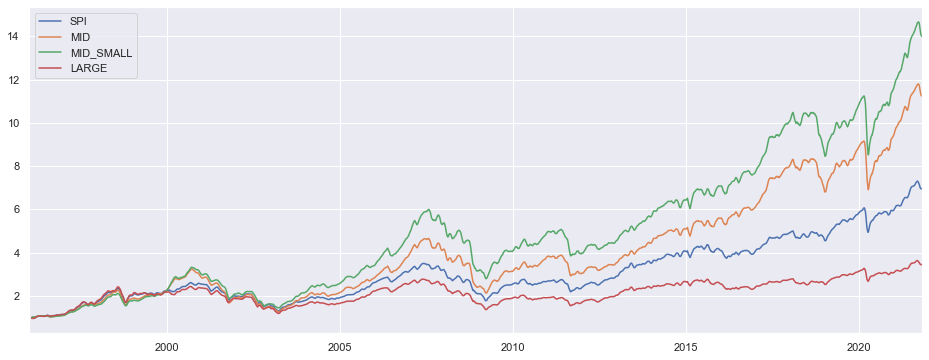

In [7]:
fig, ax = plt.subplots(figsize=(16,6))
(indices_price_excel.pct_change() + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [8]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [9]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [10]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [11]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [12]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'MACD', 'RSI3']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [13]:
df_X.head(5)

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01  0.022466  0.038097  0.040318  0.107268  0.033299  0.015894   
1997-01-02  0.021632  0.037319  0.040097  0.106482  0.032779  0.018607   
1997-01-03  0.025088  0.040894  0.044240  0.111435  0.036276  0.021194   
1997-01-06  0.029491  0.045517  0.049446  0.115450  0.046129  0.042128   
1997-01-07  0.031842  0.048303  0.052813  0.114716  0.054543  0.035250   

                                                                      \
                vol12       vol6       vol1     RSI14      RSI9 MACD   
1997-01-01  54.359759  54.247790  16.733889  0.735158  0.909276  1.0   
1997-01-02  54.301648  54.932420  17.434473  0.824030  0.878268  1.0   
1997-01-03  54.307861  55.743792  18.829687  0.832718  1.000000  1.0   
1997-01-06  54.440097  56.770481  18.087986  0.947918  1.000000  1.0   
1997-01-07  54.703999  57.930561  19.846867  0.949648  1.000000  1.0   

                      MID_SMALL                                          \
                 RSI3      ma50     ma100     ma200     mom12      mom6   
1997-01-01  39.436606  0.018250  0.032371  0.032898  0.096087  0.026019   
1997-01-02  40.100131  0.017542  0.031737  0.032707  0.095700  0.026381   
1997-01-03  41.870434  0.017724  0.032039  0.033423  0.095889  0.026108   
1997-01-06  44.883073  0.022928  0.037445  0.039284  0.101706  0.035178   
1997-01-07  48.240932  0.026625  0.041522  0.043847  0.101996  0.044610   

                                                                               \
                mom1      vol12       vol6      vol1     RSI14      RSI9 MACD   
1997-01-01  0.007762  10.185876   9.567676  2.233779  0.684020  0.884224  1.0   
1997-01-02  0.009727  10.150741   9.681898  2.455944  0.764753  0.858915  1.0   
1997-01-03  0.007798  10.118655   9.797445  2.666495  0.739247  0.858915  1.0   
1997-01-06  0.027631  10.108729   9.959434  2.879525  0.873916  1.000000  1.0   
1997-01-07  0.025128  10.131686  10.160475  3.452833  0.886202  1.000000  1.0   

                         LARGE                                          \
                RSI3      ma50     ma100     ma200     mom12      mom6   
1997-01-01  6.143464  0.023189  0.040553  0.062232  0.219023  0.044734   
1997-01-02  6.363741  0.022210  0.039771  0.061825  0.211196  0.040707   
1997-01-03  6.562708  0.020736  0.038527  0.060896  0.223900  0.034147   
1997-01-06  7.104269  0.015760  0.033697  0.056387  0.204432  0.036452   
1997-01-07  7.825788  0.014543  0.032876  0.055787  0.205896  0.044602   

                                                                             \
                mom1       vol12        vol6       vol1     RSI14      RSI9   
1997-01-01  0.004510  184.851943  110.078930  33.052024  0.692056  0.768827   
1997-01-02  0.008081  184.295583  111.326139  34.950821  0.766167  0.748332   
1997-01-03  0.006720  183.372518  112.449337  36.425919  0.714199  0.849567   
1997-01-06  0.023022  182.636808  113.421332  35.193602  0.725153  0.762136   
1997-01-07  0.012623  181.813920  114.392678  35.576269  0.674269  0.755534   

                                 
                MACD       RSI3  
1997-01-01  0.810559  66.997240  
1997-01-02  0.000000  69.689354  
1997-01-03  0.000000  71.091320  
1997-01-06  0.000000  69.347797  
1997-01-07  0.000000  67.420480

In [14]:
def strategie(df_input_all, price, rebalance_freq, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=8, month_test_period=5, training_window=5, batch_size=1, verbose=0):
    
    first_end_date = '2002-02-01'
    num_tickers = len(df_input_all.columns.get_level_values(0).unique())
    num_features = len(df_input_all.columns.get_level_values(1).unique())
    
    returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
    best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]
    
    prob_output = []
    pred_output = []
    
    if rebalance_freq == 'M':
        # The moving window every 6 month
        all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    else:
        # The moving window every 26 weeks
        all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index
    
    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)
        
        # The first date input must before the first date output
        if rebalance_freq =='M':
            # Make sur the input period start the 1st of the month
            start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
        else:
            start_date_input = start_date - relativedelta(days=input_period)
            # Make sur the input period start a monday
            start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            # If we rebalance monthly, the input data will be weekly data
            if rebalance_freq == 'M':
                df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            # If we rebalance weekly, the input data will be daily data
            else:
                df_input_period = df_input.loc[:idx].iloc[-input_period:]
                
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values
        
        # Find the first prediction date
        if i == 0:
            if rebalance_freq == 'M':
                first_start_date_test = end_date - relativedelta(months=5)
            else:
                first_start_date_test = end_date - relativedelta(weeks=25)
        
        if rebalance_freq == 'M':
            start_date_test = (end_date - relativedelta(months=5))
            # Make sur the first test date is the end of the month
            year_test, month_test = start_date_test.year, start_date_test.month
            start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
            split_index = df_output.index.get_loc(start_date_test)    
        else:
            start_date_test = end_date - relativedelta(weeks=25)
            # Make sur the first test date is a friday
            delta_days = 4 - start_date_test.weekday()
            if delta_days < 0:
                delta_days += 7
            start_date_test = start_date_test + relativedelta(days=delta_days)
            split_index = df_output.index.get_loc(start_date_test)  
        
        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]
        
        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
        
        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)
    
        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        
        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                             hidden_size=hidden_size, num_layers=num_layers)
        
        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        
        # Train the model
        train(model, X_train, y_train, X_test, y_test, nb_epochs_all, i, batch_size=batch_size, verbose=verbose)

        # Get predictions
        prob, pred = test(model, X_test, y_test, threshold=0.45)
        pred_output.append(pred)
        prob_output.append(prob)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    
    return df_pred, df_prob

In [15]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
models_list = ['MLP', 'ConvNet']
#models_list = ['ConvNet']
df_pred_dict = {}
df_prob_dict = {}
perf_pred_dict_gross = {}
perf_pred_dict_net = {}

input_period = 15
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'W-FRI'

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], df_prob_dict[model_name] = strategie(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                                                   model_name=model_name, nb_epochs=nb_epochs, 
                                                                   nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                                                   batch_size=batch_size, verbose=verbose, 
                                                                   training_window=training_window)
    
    #perf_pred_dict_gross[model_name] = pred_to_perf(df_pred_dict[model_name], daily_returns)
    #perf_pred_dict_net[model_name] = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.0012)
    
    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]
        
df_prob_dict['Ensemble'] /= len(models_list)
#df_pred_dict['Ensemble'] = df_prob_ensemble.rank(axis=1).replace({1: 0., 2: 0., 3: 1.})

100%|██████████| 40/40 [00:04<00:00,  9.48it/s]


In [36]:
df_pred_dict['Ensemble'] = pd.DataFrame().reindex_like(df_prob_dict['Ensemble']).fillna(0)
cols = df_pred_dict['Ensemble'].columns
for k in range(0, len(df_pred_dict['Ensemble'])):
    if k == 0:
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
    else:
        out = df_prob_dict['Ensemble'].iloc[k].max()
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        if out > 0.45:
            df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
        else:
            df_pred_dict['Ensemble'].iloc[k] = df_pred_dict['Ensemble'].iloc[k-1]

In [37]:
perf_bench = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

In [38]:
bench_stats = perf_to_stat(perf_bench, perf_bench)
stats = []
stats.append(bench_stats + [0])
for model_name in df_pred_dict:
    
    perf_gross = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.)
    perf_net = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.0012)
    
    turnover_num = turnover(df_pred_dict[model_name])
    stats.append(perf_to_stat(perf_gross, perf_net) + [turnover(df_pred_dict[model_name])])
stats = np.array(stats)

df_stats = pd.DataFrame(data=stats, columns=['Gross avg. annual return (%)', 'Net avg. annual return (%)', 
                                             'Avg. annual vol. (%)', 'Avg Sharpe ratio', 
                                             'Max. Drawdown (%)', 'Turnover'], 
                        index=['Benchmark SPI'] + list(df_pred_dict.keys())).round(2)

df_stats.Turnover = df_stats.Turnover.apply(int)
df_stats

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,7.35,7.35,17.41,0.42,44.52,0
MLP,8.56,7.04,17.32,0.41,41.54,252
ConvNet,7.55,7.07,17.35,0.41,49.01,77
Ensemble,7.30,6.52,17.24,0.38,49.88,128


In [39]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

,MLP,ConvNet
MLP,1.00,0.57
ConvNet,0.57,1.00


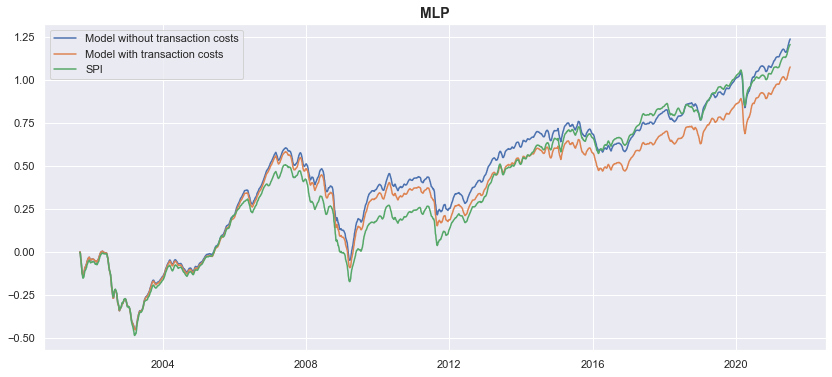

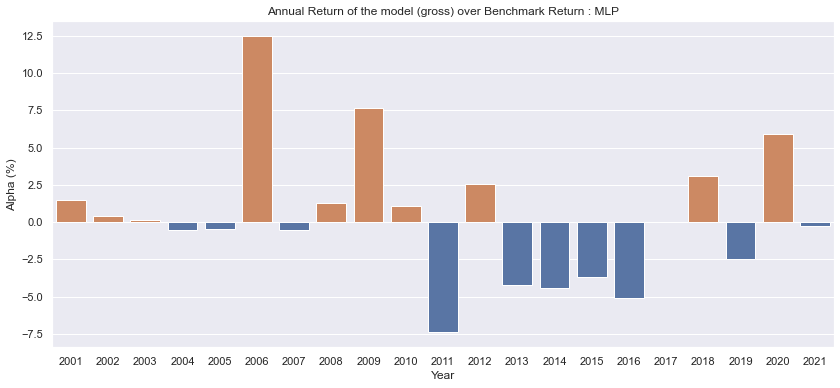

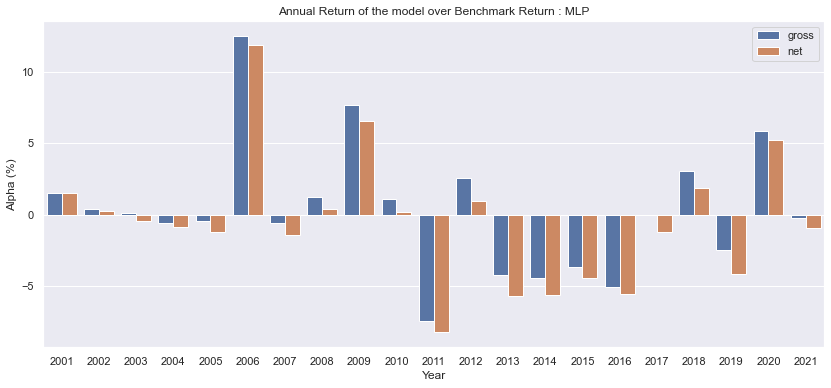

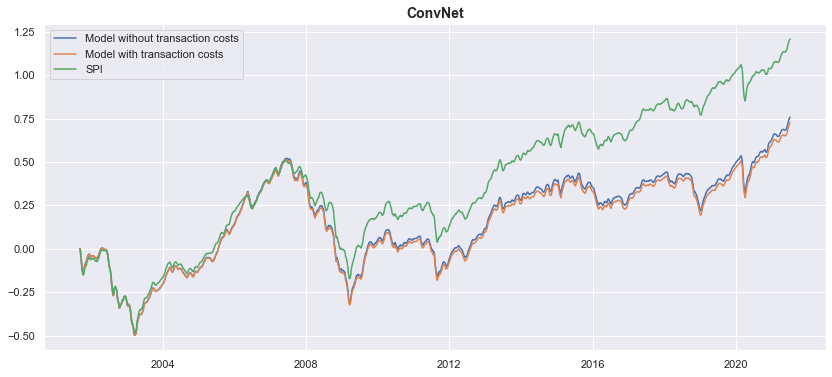

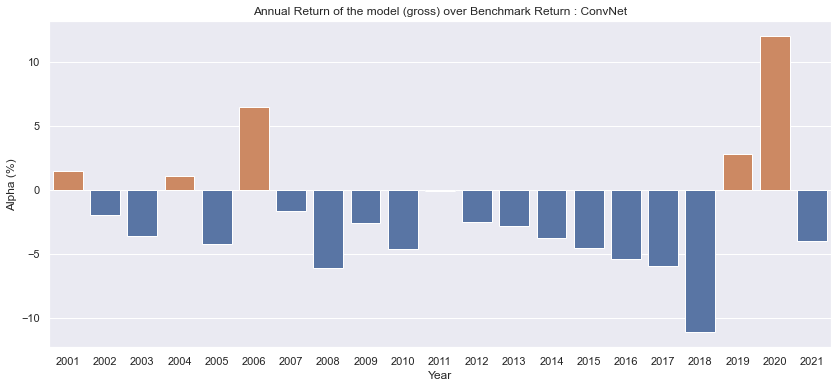

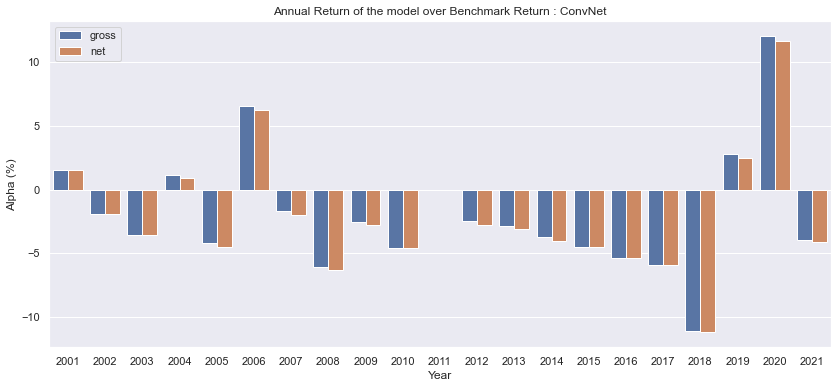

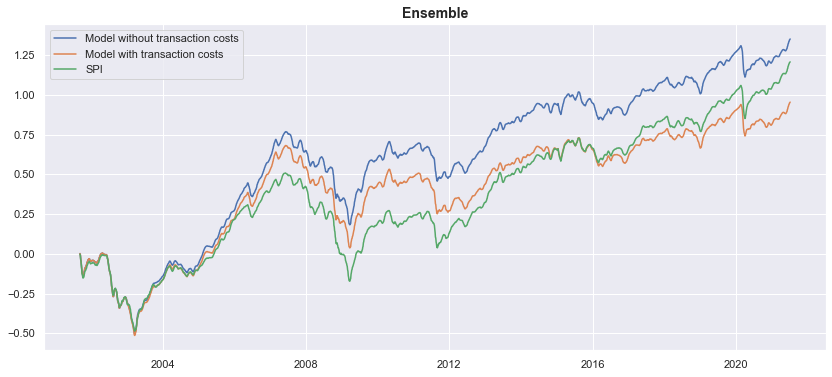

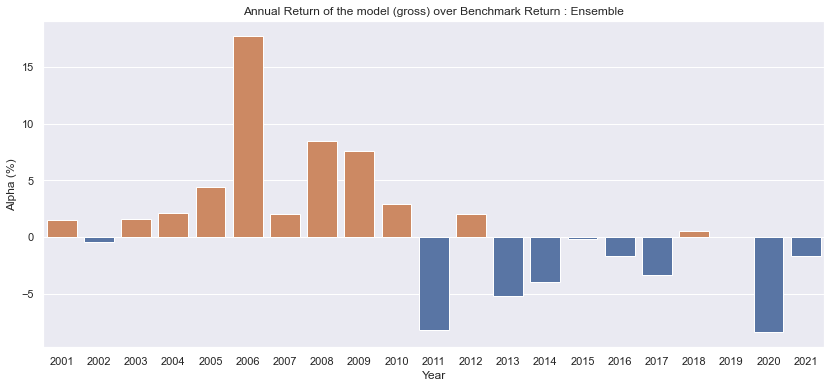

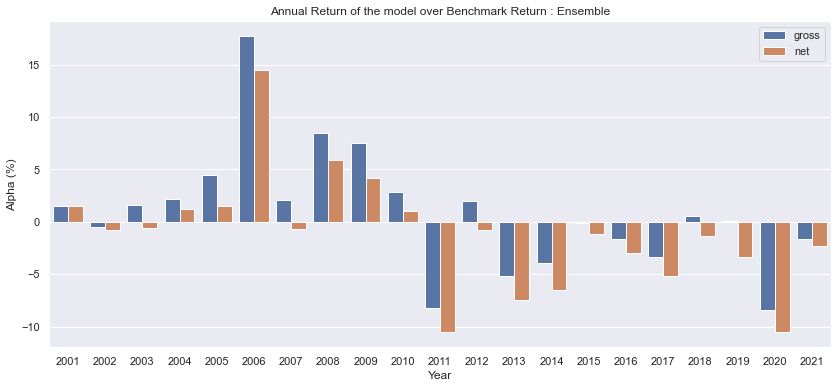

In [17]:
for model_name in df_pred_dict:
    performance_plot(df_pred_dict[model_name], model_name, daily_returns, bench_price)
    annual_alpha_plot(perf_bench, df_pred_dict[model_name], model_name, daily_returns)
    annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model_name], model_name, daily_returns)

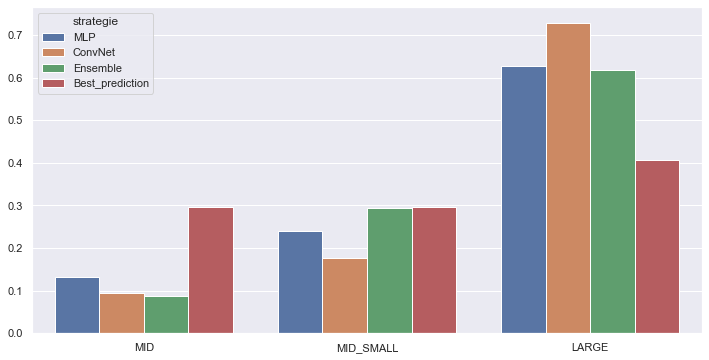

In [18]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)
    
returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]
df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [21]:
input_period = 15
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'W-FRI'

model_name = 'MLP'

first_end_date = '2002-02-01'
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]

prob_output = []
pred_output = []

if rebalance_freq == 'M':
    # The moving window every 6 month
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
else:
    # The moving window every 26 weeks
    all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    # The first date input must before the first date output
    if rebalance_freq =='M':
        # Make sur the input period start the 1st of the month
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
    else:
        start_date_input = start_date - relativedelta(days=input_period)
        # Make sur the input period start a monday
        start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        # If we rebalance monthly, the input data will be weekly data
        if rebalance_freq == 'M':
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        # If we rebalance weekly, the input data will be daily data
        else:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]

        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        if rebalance_freq == 'M':
            first_start_date_test = end_date - relativedelta(months=5)
        else:
            first_start_date_test = end_date - relativedelta(weeks=25)

    if rebalance_freq == 'M':
        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
    else:
        start_date_test = end_date - relativedelta(weeks=25)
        # Make sur the first test date is a friday
        delta_days = 4 - start_date_test.weekday()
        if delta_days < 0:
            delta_days += 7
        start_date_test = start_date_test + relativedelta(days=delta_days)
        split_index = df_output.index.get_loc(start_date_test)  

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)


    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                         hidden_size=hidden_size, num_layers=num_layers)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs

    # Train the model
    train(model, X_train, y_train, X_test, y_test, nb_epochs_all, i, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, pred = test(model, X_test, y_test)
    pred_output.append(pred)
    prob_output.append(prob)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

return df_pred, df_prob

100%|██████████| 40/40 [00:04<00:00,  8.84it/s]
